In [17]:
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

/home/anson/.local/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [32]:
cm = 3
mN = 1

# V2 = 1e-4
V2 = 1

modes_dt = {0: {'mode': f'../features_ISR/bg_2W_E-{cm}_reco.root', 'yields': 1.80e4}, 
            1: {'mode': f'../features_ISR/bg_sZ_E-{cm}_reco.root', 'yields': 1.76e2*V2},
#             2: {'mode': f'../features_ISR/signal_tchannel_reco_E-{cm}TeV_N-{mN}TeV.root', 'yields': 1.18e6*V2}
           }

In [33]:
def load_train_test(modes_dt, size=0.5):
    np.random.seed(9)
    df_train = pd.DataFrame()
    df_test = pd.DataFrame()
    num_lt = []
    
    # loop over different modes
    for i, (k, v) in enumerate(modes_dt.items()):
        file = uproot.open(v['mode'])
        df_i = pd.DataFrame(np.array(file['t']['features'].array()))
        df_i['target'] = i    # add the target label
        df_i['weight'] = v['yields']/len(df_i)
        num_lt.append(len(df_i))

        # shuffle the index for training and testing sets
        idx = df_i.index.tolist()
        np.random.shuffle(idx)
        
        # cut according to the fraction
        cut = int(np.ceil(len(idx) * size))
        df_train_i = df_i.loc[idx[:cut]]
        df_test_i = df_i.loc[idx[cut:]]
        
        # Put to the global dataframs
        df_train = pd.concat([df_train, df_train_i])
        df_test = pd.concat([df_test, df_test_i])
    
    df_train.reset_index(drop=True, inplace=True)
    df_test.reset_index(drop=True, inplace=True)
    
    print('train size: {} ({:.2f}%); test size: {} ({:.2f}%)'.format(len(df_train), 100*len(df_train)/(len(df_train)+len(df_test)), len(df_test), 100*len(df_test)/(len(df_train)+len(df_test))))
    print('data points per mode: ',num_lt)
    return df_train, df_test

    

In [34]:
tr_te_size = 0.5 
df_train, df_test = load_train_test(modes_dt, tr_te_size)

train size: 25739 (50.00%); test size: 25738 (50.00%)
data points per mode:  [22458, 29019]


In [35]:
df_train.columns

Index(['iEvt', 'ptLep', 'etaLep', 'phiLep', 'ELep', 'pxLep', 'pyLep', 'pzLep',
       'typeLep', 'typeLep2', 'ptJet1', 'etaJet1', 'phiJet1', 'EJet1',
       'ptJet2', 'etaJet2', 'phiJet2', 'EJet2', 'DeltaPhijjl', 'DeltaRjj',
       'DeltaRjjl', 'nJets', 'ptJJ', 'etaJJ', 'phiJJ', 'mJJ', 'mN', 'ptN',
       'etaN', 'phiN', 'pxN', 'pyN', 'pzN', 'chargeLep', 'MET', 'pTheta',
       'MinPtLep', 'DeltaPhiNMET', 'ptLepTrue', 'etaLepTrue', 'phiLepTrue',
       'ELepTrue', 'ptJet1True', 'etaJet1True', 'phiJet1True', 'EJet1True',
       'ptJet2True', 'etaJet2True', 'phiJet2True', 'EJet2True', 'DeltaRjjTrue',
       'DeltaRjjlTrue', 'ptJJTrue', 'etaJJTrue', 'phiJJTrue', 'mJJTrue',
       'mNTrue', 'ptNTrue', 'etaNTrue', 'phiNTrue', 'ENTrue', 'pzNTrue',
       'chargeLepTrue', 'typeLepTrue', 'pxLepTrue', 'pyLepTrue', 'pzLepTrue',
       'pxNTrue', 'pyNTrue', 'bkgPIDV1', 'bkgPIDV2', 'target', 'weight'],
      dtype='object')

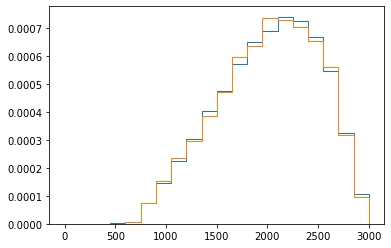

In [40]:
bins_=20
range_=[0, 3000]
plt.hist(df_train[df_train.target==1].mN, density=True, bins=bins_, range=range_, histtype='step');
plt.hist(df_train[df_train.target==0].mN, density=True, bins=bins_, range=range_, histtype='step');

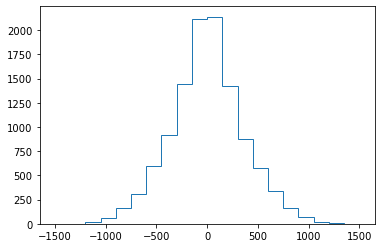

In [41]:
bins_=20
range_=[-1500, 1500]
plt.hist(df_train[df_train.target==0].pzN, bins=bins_, range=range_, histtype='step');